In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
def validFiles(files):
    validFiles = []
    for file in files:
        if os.path.exists(file):
            validFiles.append(file)
    return validFiles

colorForSchemes = {
    "Static": "blue",
    "CMI": "green",
    "SI": "red",
    "NC": "orange",
}

# Read all Files

In [2]:
def getISScheme(studyTitle):
    return studyTitle.split('_')[0]

def getCTScheme(studyTitle):
    # remove everything before the first _ but keep the rest including "_"
    split = studyTitle.split('_')
    return '_'.join(split[1:])

# basic definitions
idleSlopeSchemes = ['Static', 'CMI', 'SI', 'NC']
crossTrafficSchemes = ['NoCT', 'NoCT_NoPCTRes', 'BECT', 'BECT_NoPCTRes', 'PCT']
studyTitles = []
for idleSlopeScheme in idleSlopeSchemes:
    for crossTrafficScheme in crossTrafficSchemes:
        if ((idleSlopeScheme == 'Static' and crossTrafficScheme == 'NoCT_NoPCTRes') 
            or (idleSlopeScheme == 'Static' and crossTrafficScheme == 'BECT_NoPCTRes')):
            continue
        studyTitles.append(idleSlopeScheme + '_' + crossTrafficScheme)
studyTitles

['Static_NoCT',
 'Static_BECT',
 'Static_PCT',
 'CMI_NoCT',
 'CMI_NoCT_NoPCTRes',
 'CMI_BECT',
 'CMI_BECT_NoPCTRes',
 'CMI_PCT',
 'SI_NoCT',
 'SI_NoCT_NoPCTRes',
 'SI_BECT',
 'SI_BECT_NoPCTRes',
 'SI_PCT',
 'NC_NoCT',
 'NC_NoCT_NoPCTRes',
 'NC_BECT',
 'NC_BECT_NoPCTRes',
 'NC_PCT']

## Read Simulation Results (Subdir sim/)
Open the Study as an anf-File and select the relevant data in OMNeT++ IDE.
Right click and select "Export Data" -> "JSON" -> Select Use NumPy arrays, and other settings specified below.

Studies are formed for all IdleSlope schemes:
- Static
- CMI 
- Stream Interval (SI)
- Network Calculus (NC) -- from DYRECTsn Framework

For all schemes the following permutations are executed:
- NoCT
- NoCT_NoPCTRes (not for static scheme, as it is not applicable)
- BECT
- BECT_NoPCTRes (not for static scheme, as it is not applicable)
- PCT

The %STUDY% is formed by the scheme and the permutation, e.g. `Static_NoCT` or `SI_BECT_NoPCTRes`.

Table for the settings, all results are Vectors
| Module Filter | Result Name | Target File | Start Time | End Time |
|---------------|-------------|-------------|------------|----------|
| `**.aggregateSwitch.etherMAC[0].**.transmissionSelectionAlgorithm[7]` | reservedBandwidth:vector | `sim/%STUDY%_AggregateIdleSlopes.json` | 0s | 0.2s |
| `**.stageSwitch[*].etherMAC[1].**.transmissionSelectionAlgorithm[7]` | reservedBandwidth:vector | `sim/%STUDY%_StageIdleSlopes.json` | 0s | 0.2s |
| `**.sink.middleware.subscriberEndpoints[*]` | endpointCreatedAt:sum (scalar!) | `sim/%STUDY%_SinkCreated.json` | 0s | 0.2s |
| `**.talkerSrc[*].middleware.publisherEndpoints[*]` | endpointCreatedAt:sum (scalar!) | `sim/%STUDY%_TalkerCreated.json` | 0s | 0.2s |
| `**.talkerSrc[*].middleware.publisherEndpoints[*]` | connectedRemotes:vector | `sim/%STUDY%_TalkerRemotes.json` | 0s | 0.2s |
| `**.aggregateSwitch.etherMAC[0].**.queue[7]` | delay:vector | `sim/%STUDY%_AggregateDelay.json` | 0.1s | 0.3s |
| `**.aggregateSwitch.etherMAC[0].**.queue[7]` | length:vector | `sim/%STUDY%_AggregateQueue.json` | 0.1s | 0.3s |
| `**.sink.services[*]` | rxLatency:vector | `sim/%STUDY%_SinkDelay.json` | 0.1s | 0.3s |


In [3]:
def buildSimFileName(studyTitle, valueName):
    return 'simScave/' + studyTitle + "_" + valueName + '.json'

def getValueNameFromSimFileName(simFileName):
    split = simFileName.split('/')[-1].split('.')[0].split('_')
    return split[-1]

def getStudyTitleFromSimFileName(simFileName):
    split = simFileName.split('/')[-1].split('.')[0].split('_')
    return '_'.join(split[:-1])


In [12]:
simAggregateSlopeFiles = []
simStageSlopeFiles = []
simNCStageSlopeFiles = []
simSubCreatedFiles = []
simPubCreatedFiles = []
simPubRemotesFiles = []
simQueueFiles = []
simDelayFiles = []
simSinkDelayFiles = []
for studyTitle in studyTitles:
    simAggregateSlopeFiles.append(buildSimFileName(studyTitle, 'AggregateIdleSlopes'))
    simStageSlopeFiles.append(buildSimFileName(studyTitle, 'StageIdleSlopes'))
    simSubCreatedFiles.append(buildSimFileName(studyTitle, 'SinkCreated'))
    simPubCreatedFiles.append(buildSimFileName(studyTitle, 'TalkerCreated'))
    simPubRemotesFiles.append(buildSimFileName(studyTitle, 'TalkerRemotes'))
    simQueueFiles.append(buildSimFileName(studyTitle, 'AggregateQueue'))
    simDelayFiles.append(buildSimFileName(studyTitle, 'AggregateDelay'))
    simSinkDelayFiles.append(buildSimFileName(studyTitle, 'SinkDelay'))
    if "NC" in studyTitle:
        simNCStageSlopeFiles.append(buildSimFileName(studyTitle, 'StageIdleSlopes'))

# check if the files exist and remove the ones that do not from the list
simAggregateSlopeFiles = validFiles(simAggregateSlopeFiles)
simStageSlopeFiles = validFiles(simStageSlopeFiles)
simNCStageSlopeFiles = validFiles(simNCStageSlopeFiles)
simSubCreatedFiles = validFiles(simSubCreatedFiles)
simPubCreatedFiles = validFiles(simPubCreatedFiles)
simPubRemotesFiles = validFiles(simPubRemotesFiles)
simQueueFiles = validFiles(simQueueFiles)
simDelayFiles = validFiles(simDelayFiles)
simSinkDelayFiles = validFiles(simSinkDelayFiles)

print ("valid sim files found:")
print (simAggregateSlopeFiles)
print (simStageSlopeFiles)
print (simNCStageSlopeFiles)
print (simSubCreatedFiles)
print (simPubCreatedFiles)
print (simPubRemotesFiles)
print (simQueueFiles)
print (simDelayFiles)
print (simSinkDelayFiles)

valid sim files found:
['simScave/Static_NoCT_AggregateIdleSlopes.json', 'simScave/Static_BECT_AggregateIdleSlopes.json', 'simScave/Static_PCT_AggregateIdleSlopes.json', 'simScave/CMI_NoCT_AggregateIdleSlopes.json', 'simScave/CMI_NoCT_NoPCTRes_AggregateIdleSlopes.json', 'simScave/CMI_BECT_AggregateIdleSlopes.json', 'simScave/CMI_BECT_NoPCTRes_AggregateIdleSlopes.json', 'simScave/CMI_PCT_AggregateIdleSlopes.json', 'simScave/SI_NoCT_AggregateIdleSlopes.json', 'simScave/SI_NoCT_NoPCTRes_AggregateIdleSlopes.json', 'simScave/SI_BECT_AggregateIdleSlopes.json', 'simScave/SI_BECT_NoPCTRes_AggregateIdleSlopes.json', 'simScave/SI_PCT_AggregateIdleSlopes.json', 'simScave/NC_NoCT_AggregateIdleSlopes.json', 'simScave/NC_NoCT_NoPCTRes_AggregateIdleSlopes.json', 'simScave/NC_BECT_AggregateIdleSlopes.json', 'simScave/NC_BECT_NoPCTRes_AggregateIdleSlopes.json', 'simScave/NC_PCT_AggregateIdleSlopes.json']
['simScave/Static_NoCT_StageIdleSlopes.json', 'simScave/Static_BECT_StageIdleSlopes.json', 'simScav

### Reserverd Bandwidth for Aggregate and Stage Switches

In [13]:
def getMaxIdleSlopesForSimStudy(simFile, returnFirst=False):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxIdleSlope = 0
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                maxIdleSlope = np.max([np.max(vector["value"]),maxIdleSlope])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = int(maxIdleSlope)
    return results

def getMinIdleSlopesForSimStudy(simFile, returnFirst=False):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        minIdleSlope = 1000000000 # gigabit max slope
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                minIdleSlope = np.min([np.max(vector["value"]),minIdleSlope]) ## take the max of each run but the min of all runs
                if returnFirst:
                    break
        results[(inputLinks,stages)] = int(minIdleSlope)
    return results

def getAvgIdleSlopesForSimStudy(simFile):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        sumIdleSlope = 0 
        values = 0
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                sumIdleSlope += np.max(vector["value"]) ## take the max of each run but the min of all runs
                values += 1
        avgIdleSlope = int(sumIdleSlope/values)
        results[(inputLinks,stages)] = avgIdleSlope
    return results

def getAllIdleSlopesForSimStudy(simFile):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        idleSlopes = dict()
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                module = vector["module"]
                stage = int(module.split(".")[2].split("[")[-1].replace("]",""))
                idleSlopes[stage] = int(np.max(vector["value"]))
        results[(inputLinks,stages)] = idleSlopes
    return results

def getSlopesForStudyFiles(simFiles, operator="first"):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        if operator == "first":
            results[isScheme][ctScheme] = getMaxIdleSlopesForSimStudy(simFile, True)
        elif operator == "max":
            results[isScheme][ctScheme] = getMaxIdleSlopesForSimStudy(simFile, False)
        elif operator == "min":
            results[isScheme][ctScheme] = getMinIdleSlopesForSimStudy(simFile, False)
        elif operator == "avg":
            results[isScheme][ctScheme] = getAvgIdleSlopesForSimStudy(simFile)
        elif operator == "all":
            results[isScheme][ctScheme] = getAllIdleSlopesForSimStudy(simFile)
    return results


In [14]:
simAggregateIdleSlopes = getSlopesForStudyFiles(simAggregateSlopeFiles, "first")
print(simAggregateIdleSlopes)

{'Static': {'NoCT': {(10, 1): 75000000, (10, 10): 75000000, (10, 2): 75000000, (10, 3): 75000000, (10, 4): 75000000, (10, 5): 75000000, (10, 8): 75000000, (10, 9): 75000000, (10, 6): 75000000, (10, 7): 75000000, (11, 1): 75000000, (11, 10): 75000000, (11, 2): 75000000, (11, 3): 75000000, (11, 6): 75000000, (11, 7): 75000000, (11, 4): 75000000, (11, 5): 75000000, (11, 8): 75000000, (11, 9): 75000000, (12, 10): 75000000, (12, 1): 75000000, (12, 2): 75000000, (12, 3): 75000000, (12, 4): 75000000, (12, 6): 75000000, (12, 7): 75000000, (12, 5): 75000000, (12, 8): 75000000, (12, 9): 75000000, (13, 10): 75000000, (13, 1): 75000000, (13, 2): 75000000, (13, 3): 75000000, (13, 4): 75000000, (13, 6): 75000000, (13, 7): 75000000, (13, 5): 75000000, (2, 2): 75000000, (2, 5): 75000000, (2, 3): 75000000, (2, 8): 75000000, (2, 9): 75000000, (2, 4): 75000000, (13, 8): 75000000, (13, 9): 75000000, (2, 1): 75000000, (2, 10): 75000000, (2, 6): 75000000, (2, 7): 75000000, (3, 2): 75000000, (3, 3): 75000000

In [15]:
simMaxStageIdleSlopes = getSlopesForStudyFiles(simStageSlopeFiles, "max")
simMinStageIdleSlopes = getSlopesForStudyFiles(simStageSlopeFiles, "min")
simAvgStageIdleSlopes = getSlopesForStudyFiles(simStageSlopeFiles, "avg")
print(simMaxStageIdleSlopes)
print(simMinStageIdleSlopes)
print(simAvgStageIdleSlopes)

{'Static': {'NoCT': {(10, 1): 75000000, (10, 10): 75000000, (10, 2): 75000000, (10, 3): 75000000, (10, 4): 75000000, (10, 5): 75000000, (10, 8): 75000000, (10, 9): 75000000, (10, 6): 75000000, (10, 7): 75000000, (11, 1): 75000000, (11, 10): 75000000, (11, 2): 75000000, (11, 3): 75000000, (11, 6): 75000000, (11, 7): 75000000, (11, 4): 75000000, (11, 5): 75000000, (11, 8): 75000000, (11, 9): 75000000, (12, 10): 75000000, (12, 1): 75000000, (12, 2): 75000000, (12, 3): 75000000, (12, 4): 75000000, (12, 6): 75000000, (12, 7): 75000000, (12, 5): 75000000, (12, 8): 75000000, (12, 9): 75000000, (13, 10): 75000000, (13, 1): 75000000, (13, 2): 75000000, (13, 3): 75000000, (13, 4): 75000000, (13, 6): 75000000, (13, 7): 75000000, (13, 5): 75000000, (2, 2): 75000000, (2, 5): 75000000, (2, 3): 75000000, (2, 8): 75000000, (2, 9): 75000000, (2, 4): 75000000, (13, 8): 75000000, (13, 9): 75000000, (2, 1): 75000000, (2, 10): 75000000, (2, 6): 75000000, (2, 7): 75000000, (3, 2): 75000000, (3, 3): 75000000

In [16]:
simNcStageIdleSlopes = getSlopesForStudyFiles(simNCStageSlopeFiles, "all")
print(simNcStageIdleSlopes)

{'NC': {'NoCT': {(10, 1): {0: 66227733}, (10, 10): {0: 66227733, 1: 54814654, 2: 54245325, 3: 53661465, 4: 53062511, 5: 52447872, 6: 51816921, 7: 51169002, 8: 50503420, 9: 49819443}, (10, 2): {0: 66227733, 1: 49819443}, (10, 3): {0: 66227733, 1: 50503420, 2: 49819443}, (10, 4): {0: 66227733, 1: 51169002, 2: 50503420, 3: 49819443}, (10, 6): {0: 66227733, 1: 52447872, 2: 51816921, 3: 51169002, 4: 50503420, 5: 49819443}, (10, 5): {0: 66227733, 1: 51816921, 2: 51169002, 3: 50503420, 4: 49819443}, (10, 9): {0: 66227733, 1: 54245325, 2: 53661465, 3: 53062511, 4: 52447872, 5: 51816921, 6: 51169002, 7: 50503420, 8: 49819443}, (11, 1): {0: 65047443}, (10, 7): {0: 66227733, 1: 53062511, 2: 52447872, 3: 51816921, 4: 51169002, 5: 50503420, 6: 49819443}, (10, 8): {0: 66227733, 1: 53661465, 2: 53062511, 3: 52447872, 4: 51816921, 5: 51169002, 6: 50503420, 7: 49819443}, (11, 10): {0: 65047443, 1: 55308266, 2: 54739982, 3: 54157060, 4: 53558926, 5: 52944978, 6: 52314579, 7: 51667061, 8: 51001715, 9: 50

### Aggregate Switch Max Queue Length

In [8]:
def getMaxQueueForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxQueue = 0
        for vector in sim[study]["vectors"]:
            if "length" in vector["name"]:
                maxQueue = np.max([np.max(vector["value"]),maxQueue])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxQueue
    return results

def getMaxQueueForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxQueueForSimStudy(simFile, returnFirst)
    return results

In [9]:
simAggregateQueues = getMaxQueueForStudyFiles(simQueueFiles, returnFirst=True)
print(simAggregateQueues)

{'Static': {'NoCT': {(10, 1): 9, (10, 10): 9, (10, 2): 9, (10, 3): 9, (10, 4): 9, (10, 5): 9, (10, 8): 9, (10, 9): 9, (10, 6): 9, (10, 7): 9, (11, 1): 11, (11, 10): 10, (11, 2): 10, (11, 3): 10, (11, 6): 10, (11, 7): 10, (11, 4): 10, (11, 5): 10, (11, 8): 10, (11, 9): 10, (12, 10): 11, (12, 1): 11, (12, 2): 11, (12, 3): 12, (12, 4): 11, (12, 6): 11, (12, 7): 11, (12, 5): 11, (12, 8): 11, (12, 9): 11, (13, 10): 12, (13, 1): 12, (13, 2): 12, (13, 3): 12, (13, 4): 12, (13, 6): 13, (13, 7): 12, (13, 5): 12, (2, 2): 1, (2, 5): 1, (2, 3): 1, (2, 8): 1, (2, 9): 1, (2, 4): 1, (13, 8): 12, (13, 9): 12, (2, 1): 1, (2, 10): 1, (2, 6): 1, (2, 7): 1, (3, 2): 2, (3, 3): 2, (3, 1): 2, (3, 10): 2, (3, 6): 2, (3, 7): 2, (3, 5): 2, (3, 4): 2, (4, 5): 3, (4, 6): 3, (4, 3): 3, (3, 8): 2, (3, 9): 2, (4, 1): 3, (4, 10): 3, (4, 2): 3, (4, 4): 3, (4, 8): 3, (4, 7): 3, (4, 9): 3, (5, 1): 4, (5, 10): 4, (5, 2): 4, (5, 4): 4, (5, 5): 4, (5, 3): 4, (5, 6): 4, (5, 7): 4, (5, 8): 4, (6, 2): 5, (5, 9): 4, (6, 1): 5,

### Aggregate Switch Max Queue Delay

In [59]:
def getMaxDelayForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxDelay = 0
        for vector in sim[study]["vectors"]:
            if "delay" in vector["name"]:
                maxDelay = np.max([np.max(vector["value"]),maxDelay])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxDelay
    return results

def getMaxDelayForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxDelayForSimStudy(simFile, returnFirst)
    return results

In [60]:
simAggregateDelays = getMaxDelayForStudyFiles(simDelayFiles, returnFirst=False)
print(simAggregateDelays)

{'Static': {'NoCT': {(10, 1): np.float64(0.00010782000000000001), (10, 10): np.float64(0.00010832), (10, 2): np.float64(0.00010782000000000001), (10, 3): np.float64(0.00010782000000000001), (10, 4): np.float64(0.00010782000000000001), (10, 5): np.float64(0.00010782000000000001), (10, 8): np.float64(0.00010782000000000001), (10, 9): np.float64(0.00010782000000000001), (10, 6): np.float64(0.00010782000000000001), (10, 7): np.float64(0.00010782000000000001), (11, 1): np.float64(0.00010813), (11, 10): np.float64(0.00010812), (11, 2): np.float64(0.00010812500000000001), (11, 3): np.float64(0.00010812), (11, 6): np.float64(0.00010812), (11, 7): np.float64(0.00010816000000000001), (11, 4): np.float64(0.00010812), (11, 5): np.float64(0.00010812), (11, 8): np.float64(0.00010812), (11, 9): np.float64(0.00010812), (12, 10): np.float64(0.00010834), (12, 1): np.float64(0.00010834), (12, 2): np.float64(0.00010834), (12, 3): np.float64(0.00010834), (12, 4): np.float64(0.00010834), (12, 6): np.float64

### Sink Delay

In [17]:
def getMaxDelayForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxDelay = 0
        for vector in sim[study]["vectors"]:
            if "rxLatency" in vector["name"]:
                maxDelay = np.max([np.max(vector["value"]),maxDelay])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxDelay
    return results

def getMaxDelayForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxDelayForSimStudy(simFile, returnFirst)
    return results

In [18]:
simSinkDelays = getMaxDelayForStudyFiles(simSinkDelayFiles, returnFirst=False)
print(simSinkDelays)

{'Static': {'NoCT': {(10, 1): np.float64(0.00014903), (10, 10): np.float64(0.000297175), (10, 2): np.float64(0.00016543500000000002), (10, 3): np.float64(0.00018184), (10, 4): np.float64(0.00019824500000000002), (10, 5): np.float64(0.00021465), (10, 8): np.float64(0.000263865), (10, 9): np.float64(0.00028027), (10, 6): np.float64(0.000231055), (10, 7): np.float64(0.00024746), (11, 1): np.float64(0.0001467), (11, 10): np.float64(0.00028641500000000004), (11, 2): np.float64(0.00016222), (11, 3): np.float64(0.00017774000000000002), (11, 6): np.float64(0.00022431500000000002), (11, 7): np.float64(0.00023988000000000001), (11, 4): np.float64(0.000193265), (11, 5): np.float64(0.00020879), (11, 8): np.float64(0.000255365), (11, 9): np.float64(0.00027089000000000003), (12, 10): np.float64(0.000277995), (12, 1): np.float64(0.00014475), (12, 2): np.float64(0.000159555), (12, 3): np.float64(0.00017436), (12, 4): np.float64(0.000189165), (12, 6): np.float64(0.00021877500000000002), (12, 7): np.flo

### Export Reserver Bandwidth for Aggregate and Stage Switches to be used in Q-Formula

In [116]:
# print a python dictionary as a lookup table for the idle slopes of the aggregate switch
print("simIdleSlopesAggregate = {")
for isSchema in simAggregateIdleSlopes:
    for ctScheme in simAggregateIdleSlopes[isSchema]:
        print("    '" + isSchema + "_" + ctScheme + "': {")
        for key in simAggregateIdleSlopes[isSchema][ctScheme]:
            print("        " + str(key) + ": " + str(simAggregateIdleSlopes[isSchema][ctScheme][key]) + ",")
        print("    },")
print("}")

simIdleSlopesAggregate = {
    'Static_NoCT': {
        (10, 1): 75000000,
        (10, 10): 75000000,
        (10, 2): 75000000,
        (10, 3): 75000000,
        (10, 4): 75000000,
        (10, 5): 75000000,
        (10, 8): 75000000,
        (10, 9): 75000000,
        (10, 6): 75000000,
        (10, 7): 75000000,
        (11, 1): 75000000,
        (11, 10): 75000000,
        (11, 2): 75000000,
        (11, 3): 75000000,
        (11, 6): 75000000,
        (11, 7): 75000000,
        (11, 4): 75000000,
        (11, 5): 75000000,
        (11, 8): 75000000,
        (11, 9): 75000000,
        (12, 10): 75000000,
        (12, 1): 75000000,
        (12, 2): 75000000,
        (12, 3): 75000000,
        (12, 4): 75000000,
        (12, 6): 75000000,
        (12, 7): 75000000,
        (12, 5): 75000000,
        (12, 8): 75000000,
        (12, 9): 75000000,
        (13, 10): 75000000,
        (13, 1): 75000000,
        (13, 2): 75000000,
        (13, 3): 75000000,
        (13, 4): 75000000,
   

In [58]:
# print a python dictionary as a lookup table for the idle slopes of the aggregate switch
print("simIdleSlopesStages = {")
for isSchema in simMaxStageIdleSlopes:
    for ctScheme in simMaxStageIdleSlopes[isSchema]:
        print("    '" + isSchema + "_" + ctScheme + "': {")
        if isSchema == "NC":
            for key in simNcStageIdleSlopes[isSchema][ctScheme]:
                # make sure simNcStageIdleSlopes[isSchema][ctScheme][key] is sorted by stage
                sortedKeys = sorted(simNcStageIdleSlopes[isSchema][ctScheme][key].keys())
                idleSlopes = ""
                for stage in sortedKeys:
                    idleSlopes += str(simNcStageIdleSlopes[isSchema][ctScheme][key][stage]) + ", "
                print("        " + str(key) + ": [" + idleSlopes + "],")
        else :
            for key in simMaxStageIdleSlopes[isSchema][ctScheme]:
                print("        " + str(key) + ": [" + str(simMaxStageIdleSlopes[isSchema][ctScheme][key]) + "],")
        print("    },")
print("}")

simIdleSlopesStages = {
    'Static_NoCT': {
        (10, 1): [75000000],
        (10, 10): [75000000],
        (10, 2): [75000000],
        (10, 3): [75000000],
        (10, 4): [75000000],
        (10, 5): [75000000],
        (10, 8): [75000000],
        (10, 9): [75000000],
        (10, 6): [75000000],
        (10, 7): [75000000],
        (11, 1): [75000000],
        (11, 10): [75000000],
        (11, 2): [75000000],
        (11, 3): [75000000],
        (11, 6): [75000000],
        (11, 7): [75000000],
        (11, 4): [75000000],
        (11, 5): [75000000],
        (11, 8): [75000000],
        (11, 9): [75000000],
        (12, 10): [75000000],
        (12, 1): [75000000],
        (12, 2): [75000000],
        (12, 3): [75000000],
        (12, 4): [75000000],
        (12, 6): [75000000],
        (12, 7): [75000000],
        (12, 5): [75000000],
        (12, 8): [75000000],
        (12, 9): [75000000],
        (13, 10): [75000000],
        (13, 1): [75000000],
        (13, 2): [75000

## Read Q-Formula Analysis Results

In [61]:
# list files in q directory
qFiles = os.listdir("q")
kmfsFiles = []
for file in qFiles:
    if "kmfs" in file:
        kmfsFiles.append(file)
qFiles = kmfsFiles
print(qFiles)

['cbsstudy_kmfs_CMI_BECT.csv', 'cbsstudy_kmfs_CMI_BECT_NoPCTRes.csv', 'cbsstudy_kmfs_CMI_NoCT.csv', 'cbsstudy_kmfs_CMI_NoCT_NoPCTRes.csv', 'cbsstudy_kmfs_CMI_PCT.csv', 'cbsstudy_kmfs_NC_BECT.csv', 'cbsstudy_kmfs_NC_BECT_NoPCTRes.csv', 'cbsstudy_kmfs_NC_NoCT.csv', 'cbsstudy_kmfs_NC_NoCT_NoPCTRes.csv', 'cbsstudy_kmfs_NC_PCT.csv', 'cbsstudy_kmfs_SI_BECT.csv', 'cbsstudy_kmfs_SI_BECT_NoPCTRes.csv', 'cbsstudy_kmfs_SI_NoCT.csv', 'cbsstudy_kmfs_SI_NoCT_NoPCTRes.csv', 'cbsstudy_kmfs_SI_PCT.csv', 'cbsstudy_kmfs_Static_BECT.csv', 'cbsstudy_kmfs_Static_NoCT.csv', 'cbsstudy_kmfs_Static_PCT.csv']


In [65]:
qAggregateDelays = dict()
qE2EDelays = dict()
for file in qFiles:
    with open("q/" + file, 'r') as f:
        split = file.replace("_kmfs", "").split('.')[0].split('_')
        siScheme = split[1]
        ctScheme = split[2]
        if split.__len__() == 4:
            ctScheme = split[2] + "_" + split[3]
        if siScheme not in qAggregateDelays:
            qAggregateDelays[siScheme] = dict()
            qE2EDelays[siScheme] = dict()
        qAggregateDelays[siScheme][ctScheme] = dict()
        qE2EDelays[siScheme][ctScheme] = dict()
        for line in f:
            if "Flow" in line: ## header... skip
                continue
            cols = line.strip().split(",")
            inputLinks = int(cols[2])
            stages = int(cols[3])
            delay = float(cols[-1])
            if "EndToEnd" in cols[4]:
                qE2EDelays[siScheme][ctScheme][(inputLinks,stages)] = delay
            else:
                qAggregateDelays[siScheme][ctScheme][(inputLinks,stages)] = delay
print("E2E: " + str(qE2EDelays))
print("Agg: " + str(qAggregateDelays))

E2E: {'CMI': {'BECT': {(2, 1): 0.003261, (3, 1): 0.003021, (4, 1): 0.002899, (5, 1): 0.003705, (6, 1): 0.003651, (7, 1): 0.003611, (8, 1): 0.003582, (9, 1): 0.003572, (10, 1): 0.003558, (11, 1): 0.003533, (12, 1): 0.003518, (13, 1): 0.003536, (2, 2): 0.004645, (3, 2): 0.004237, (4, 2): 0.004025, (5, 2): 0.004784, (6, 2): 0.004695, (7, 2): 0.00463, (8, 2): 0.004583, (9, 2): 0.004559, (10, 2): 0.004534, (11, 2): 0.004499, (12, 2): 0.004476, (13, 2): 0.004487, (2, 3): 0.00603, (3, 3): 0.005453, (4, 3): 0.005152, (5, 3): 0.005862, (6, 3): 0.005739, (7, 3): 0.00565, (8, 3): 0.005584, (9, 3): 0.005545, (10, 3): 0.005509, (11, 3): 0.005464, (12, 3): 0.005434, (13, 3): 0.005439, (2, 4): 0.007415, (3, 4): 0.006669, (4, 4): 0.006279, (5, 4): 0.006941, (6, 4): 0.006783, (7, 4): 0.006669, (8, 4): 0.006585, (9, 4): 0.006532, (10, 4): 0.006484, (11, 4): 0.00643, (12, 4): 0.006391, (13, 4): 0.00639, (2, 5): 0.008799, (3, 5): 0.007885, (4, 5): 0.007405, (5, 5): 0.008019, (6, 5): 0.007827, (7, 5): 0.00

## Read DNC Results

### Merge from all runs of a study 

In [11]:
splitFolder = "dncSplit/"
outFolder = "dnc/"
# get all files in the folder
dncSplitFiles = os.listdir(splitFolder)
merge = dict()
for file in dncSplitFiles:
    # check if the file has at least 2 lines of text
    with open(splitFolder + file) as f:
        lines = f.readlines()
        if len(lines) < 2:
            continue
    filenameSplit = file.split(".")[0].split("_")
    isScheme = filenameSplit[2]
    ctScheme = filenameSplit[3]
    ilIndex = 4
    if "IL" not in filenameSplit[4]:
        ctScheme += "_" + filenameSplit[4]
        ilIndex += 1
    inputLinks = int(filenameSplit[ilIndex].split("-")[1])
    stages = int(filenameSplit[ilIndex+1].split("-")[1])
    if isScheme not in merge:
        merge[isScheme] = dict()
    if ctScheme not in merge[isScheme]:
        merge[isScheme][ctScheme] = dict()
        merge[isScheme][ctScheme]["filename"] = "_".join(filenameSplit[0:ilIndex])
    merge[isScheme][ctScheme][(inputLinks,stages)] = pd.read_csv(splitFolder + file)
# export again to merged csv file on for each scheme pair
for isScheme in merge:
    for ctScheme in merge[isScheme]:
        minIS = 2
        maxIS = 13
        minS = 1
        maxS = 10
        studies = []
        # create a list with all possible inputLinks and stages pairs
        for i in range(minIS,maxIS+1):
            for j in range(minS,maxS+1):
                studies.append((i,j))
        filename = outFolder + merge[isScheme][ctScheme]["filename"] + ".csv"
        with open(filename, "w") as f:
            f.write("numInputLinks,numStages,talkerSize,prioCTSize,stageIdleSlope,aggregateIdleSlope,maxDelay\n")
            for key in merge[isScheme][ctScheme]:
                if key == "filename":
                    continue
                data = merge[isScheme][ctScheme][key]
                f.write(str(key[0]) + "," + str(key[1]) + "," + str(data["talkerSize"][0]) + "," + str(data["prioCTSize"][0]) + "," + str(data["stageIdleSlope"][0]) + "," + str(data["aggregateIdleSlope"][0]) + "," + str(data["maxDelay"][0]) + "\n")
                # remove the inputLinks and stages from their lists 
                studies.remove(key)
        # print filename and missing studies
        print(filename + " missing studies (" + str(studies.__len__()) + "): " + str(studies))

dnc/mds__CMI_NoCT.csv missing studies (99): [(2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 1), (3, 2), (3, 3), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 1), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (7, 1), (7, 2), (7, 3), (7, 4), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (8, 1), (8, 2), (8, 3), (8, 4), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 1), (9, 2), (9, 3), (9, 4), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (10, 1), (10, 2), (10, 3), (10, 4), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (11, 1), (11, 2), (11, 3), (11, 4), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (12, 1), (12, 2), (12, 3), (12, 4), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (13, 1), (13, 2), (13, 3), (13, 4), (13, 6), (13, 7), (13, 8), (13, 9), (13, 10)]
dnc/mds__NC_NoCT.csv missing studies (99): [(2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10),

### Read DNC Study Results

In [40]:
dncFiles = {
    # "Static": "dnc/mds_20240709_215616_static.csv",
    #"CMI_NoPCTRes": "dnc/mds_20240711_160524_CMI_NoCT_NoPCTRes.csv", # not done yet
    "CMI_NoCT": "dnc/mds_20240711_183017_CMI_NoCT.csv",# not done yet "dnc/mds__CMI_NoCT.csv", #
    # "SI_NoPCTRes": "dnc/mds_20240711_183625_SI_NoCT_NoPCTRes.csv",# not done yet
    "SI_NoCT": "dnc/mds_20240711_183259_SI_NoCT.csv",# not done yet "dnc/mds__SI_NoCT.csv", #
    # "NC_NoPCTRes": "dnc/mds_20240709_215616_nc_nopctres.csv",# not done yet
    "NC": "dnc/mds__NC_NoCT.csv", #"dnc/mds_20240709_215616_nc.csv",# not done yet "dnc/mds__NC_NoCT.csv", 
}

In [41]:
validDNCFiles = dict()
for key in dncFiles:
    if os.path.exists(dncFiles[key]):
        validDNCFiles[key] = dncFiles[key]
dncFiles = validDNCFiles
print(dncFiles)

{'CMI_NoCT': 'dnc/mds_20240711_183017_CMI_NoCT.csv', 'SI_NoCT': 'dnc/mds_20240711_183259_SI_NoCT.csv', 'NC': 'dnc/mds__NC_NoCT.csv'}


In [42]:
dncAggregateIdleSlopes = dict()
dncStageIdleSlopes = dict()
dncAggregateDelays = dict()
for key in dncFiles:
    dnc = pd.read_csv(dncFiles[key])
    for index, row in dnc.iterrows():
        stages = int(row['numStages'])
        inputLinks = int(row['numInputLinks'])
        aggregateSlope = int(row['aggregateIdleSlope'])
        stageSlopes = int(row['stageIdleSlope'])
        delay = row['maxDelay']
        if key not in dncAggregateIdleSlopes:
            dncAggregateIdleSlopes[key] = dict()
            dncStageIdleSlopes[key] = dict()
            dncAggregateDelays[key] = dict()
        dncAggregateIdleSlopes[key][(inputLinks,stages)] = aggregateSlope
        dncStageIdleSlopes[key][(inputLinks,stages)] = stageSlopes
        dncAggregateDelays[key][(inputLinks,stages)] = delay
print(dncAggregateIdleSlopes)
print(dncStageIdleSlopes)
print(dncAggregateDelays)


{'CMI_NoCT': {(2, 1): 75008000, (2, 2): 75008000, (2, 3): 75008000, (2, 4): 75008000, (2, 5): 75008000, (2, 6): 75008000, (2, 7): 75008000, (2, 8): 75008000, (2, 9): 75008000, (2, 10): 75008000, (3, 1): 75072000, (3, 2): 75072000, (3, 3): 75072000, (3, 4): 75072000, (3, 5): 75072000, (3, 6): 75072000, (3, 7): 75072000, (3, 8): 75072000, (3, 9): 75072000, (3, 10): 75072000, (4, 1): 75008000, (4, 2): 75008000, (4, 3): 75008000, (4, 4): 75008000, (4, 5): 75008000, (4, 6): 75008000, (4, 7): 75008000, (4, 8): 75008000, (4, 9): 75008000, (4, 10): 75008000, (5, 1): 75200000, (5, 2): 75200000, (5, 3): 75200000, (5, 4): 75200000, (5, 5): 75200000, (5, 6): 75200000, (5, 7): 75200000, (5, 8): 75200000, (5, 9): 75200000, (5, 10): 75200000, (6, 1): 75264000, (6, 2): 75264000, (6, 3): 75264000, (6, 4): 75264000, (6, 5): 75264000, (6, 6): 75264000, (6, 7): 75264000, (6, 8): 75264000, (6, 9): 75264000, (6, 10): 75264000, (7, 1): 75264000, (7, 2): 75264000, (7, 3): 75264000, (7, 4): 75264000, (7, 5): 7

# Read NC Results

In [26]:
# list files in the results directory
ncFolder = "nc"
ncFiles = os.listdir(ncFolder)
print(ncFiles)

['cbsstudy_individualDelays_il_10_s_1.txt', 'cbsstudy_individualDelays_il_10_s_10.txt', 'cbsstudy_individualDelays_il_10_s_10_withCT.txt', 'cbsstudy_individualDelays_il_10_s_1_withCT.txt', 'cbsstudy_individualDelays_il_10_s_2.txt', 'cbsstudy_individualDelays_il_10_s_2_withCT.txt', 'cbsstudy_individualDelays_il_10_s_3.txt', 'cbsstudy_individualDelays_il_10_s_3_withCT.txt', 'cbsstudy_individualDelays_il_10_s_4.txt', 'cbsstudy_individualDelays_il_10_s_4_withCT.txt', 'cbsstudy_individualDelays_il_10_s_5.txt', 'cbsstudy_individualDelays_il_10_s_5_withCT.txt', 'cbsstudy_individualDelays_il_10_s_6.txt', 'cbsstudy_individualDelays_il_10_s_6_withCT.txt', 'cbsstudy_individualDelays_il_10_s_7.txt', 'cbsstudy_individualDelays_il_10_s_7_withCT.txt', 'cbsstudy_individualDelays_il_10_s_8.txt', 'cbsstudy_individualDelays_il_10_s_8_withCT.txt', 'cbsstudy_individualDelays_il_10_s_9.txt', 'cbsstudy_individualDelays_il_10_s_9_withCT.txt', 'cbsstudy_individualDelays_il_11_s_1.txt', 'cbsstudy_individualDela

In [27]:
ncWcIndependentDelays = dict()
ncWcDependentDelays = dict()
for file in ncFiles:
    # read file from the back to the front
    ctScheme = "NoPCTRes"
    if "withCT" in file:
        ctScheme = "PCTRes"
    if ctScheme not in ncWcIndependentDelays:
        ncWcIndependentDelays[ctScheme] = dict()
        ncWcDependentDelays[ctScheme] = dict()
    il = int(file.split("il_")[1].split("_")[0])
    s = int(file.split("_s_")[1].split("_")[0].split(".")[0])
    with open(ncFolder + "/" + file, "r") as f:
        lines = f.readlines()
        # read lines in reverse
        for line in lines[::-1]:
            if "Successfully" in line:
                split = line.strip().split(":")[-1].split("of")
                if split[0].strip() != split[1].strip():
                    print(f"Error: reservation unsuccessful for {file}")
            if "Flow Delay" in line:
                if "Dependent" in line:
                    ncWcDependentDelays[ctScheme][(il,s)] = float(line.strip().split(":")[-1].strip().replace("ms",""))/1000
                elif "Independent" in line:
                    ncWcIndependentDelays[ctScheme][(il,s)] = float(line.strip().split(":")[-1].strip().replace("ms",""))/1000
                    break
print(ncWcIndependentDelays)
print(ncWcDependentDelays)

{'NoPCTRes': {(10, 1): 0.0056159999999999995, (10, 10): 0.008388999999999999, (10, 2): 0.0059240000000000004, (10, 3): 0.0062320000000000006, (10, 4): 0.00654, (10, 5): 0.006848, (10, 6): 0.007156, (10, 7): 0.007464, (10, 8): 0.007772, (10, 9): 0.008081, (11, 1): 0.0056159999999999995, (11, 10): 0.008388999999999999, (11, 2): 0.0059240000000000004, (11, 3): 0.0062320000000000006, (11, 4): 0.00654, (11, 5): 0.006848, (11, 6): 0.007156, (11, 7): 0.007464, (11, 8): 0.007772, (11, 9): 0.008081, (12, 1): 0.0056159999999999995, (12, 10): 0.008388999999999999, (12, 2): 0.0059240000000000004, (12, 3): 0.0062320000000000006, (12, 4): 0.00654, (12, 5): 0.006848, (12, 6): 0.007156, (12, 7): 0.007464, (12, 8): 0.007772, (12, 9): 0.008081, (13, 1): 0.0056159999999999995, (13, 10): 0.008388999999999999, (13, 2): 0.0059240000000000004, (13, 3): 0.0062320000000000006, (13, 4): 0.00654, (13, 5): 0.006848, (13, 6): 0.007156, (13, 7): 0.007464, (13, 8): 0.007772, (13, 9): 0.008081, (2, 1): 0.005615999999

# Plot the Results

## Idle Slope Analysis

In [87]:
def exportIdleSlopeConfig(file, exportResults , stages):
    with open(file, "w") as f:
        f.write("numInputLinks,numStages")
        for key in exportResults:
            f.write("," + key)
        f.write("\n")
        for key in exportResults[list(exportResults.keys())[0]]:
            f.write(str(key) + ", " + str(stages))
            for scheme in exportResults:
                f.write("," + str(exportResults[scheme][key]))
            f.write("\n")

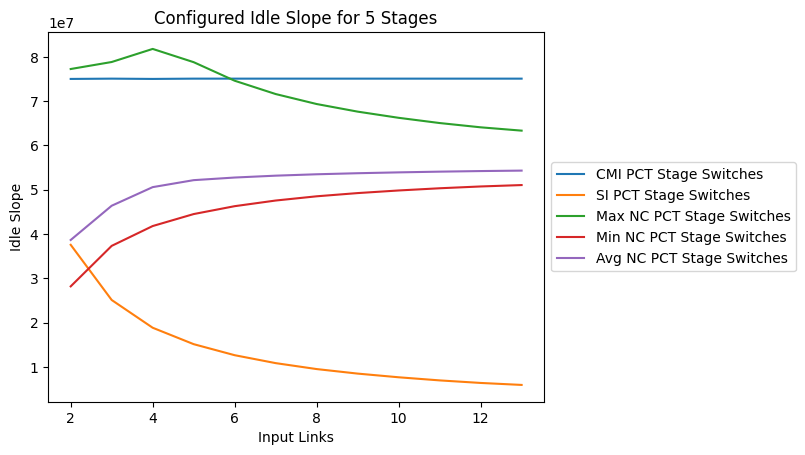

In [89]:
#For input Links and 5 Stages
stages = 5
fig, ax = plt.subplots()
exportResults = dict()
for isScheme in simMaxStageIdleSlopes:
    if isScheme == 'Static':
        continue
    ctScheme = 'PCT'
    slopes = dict()
    for key in simMaxStageIdleSlopes[isScheme][ctScheme]:
        if key[1] == stages:
            slopes[key[0]] = simMaxStageIdleSlopes[isScheme][ctScheme][key]
    slopes = dict(sorted(slopes.items()))
    name = isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
    if isScheme == "NC":
        name = "Max " + name
        exportResults["NC_Max"] = slopes
    else:
        exportResults[isScheme] = slopes
    ax.plot(slopes.keys(), slopes.values(), label=name)
    if isScheme == "NC":
        slopes = dict()
        for key in simMinStageIdleSlopes[isScheme][ctScheme]:
            if key[1] == stages:
                slopes[key[0]] = simMinStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Min " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        ax.plot(slopes.keys(), slopes.values(), label=name)
        exportResults["NC_Min"] = slopes
        slopes = dict()
        for key in simAvgStageIdleSlopes[isScheme][ctScheme]:
            if key[1] == stages:
                slopes[key[0]] = simAvgStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Avg " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        ax.plot(slopes.keys(), slopes.values(), label=name)
        exportResults["NC_Avg"] = slopes
ax.set_xlabel('Input Links')
ax.set_ylabel('Idle Slope')
ax.set_title('Configured Idle Slope for ' + str(stages) + ' Stages')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
exportIdleSlopeConfig(f"idleSlopeConfig{stages}Stages.csv", exportResults, stages)

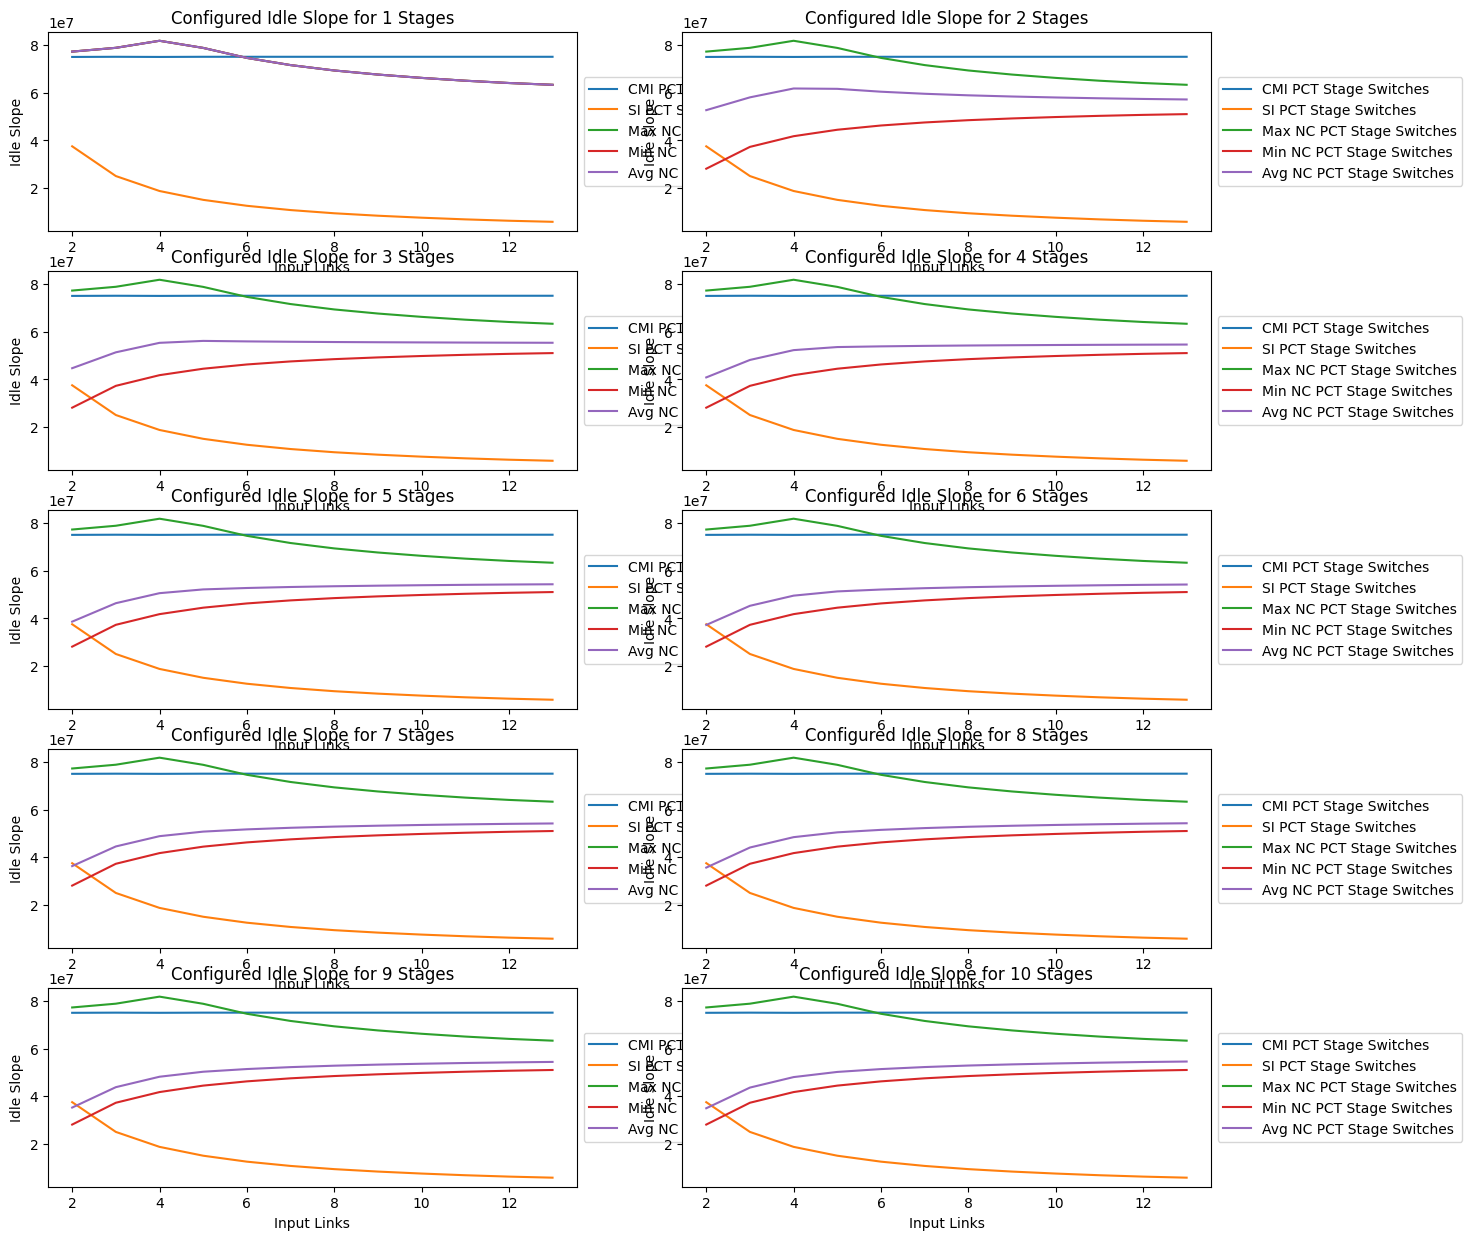

In [70]:
#For input Links and X Stages create a subplot for the 1 to 10 stages
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
for i in range(1,11):
    ax = axs[floor((i-1)/2), (i-1)%2]
    for isScheme in simMaxStageIdleSlopes:
        if isScheme == 'Static':
            continue
        ctScheme = 'PCT'
        slopes = dict()
        for key in simMaxStageIdleSlopes[isScheme][ctScheme]:
            if key[1] == i:
                slopes[key[0]] = simMaxStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        if isScheme == "NC":
            name = "Max " + name
        ax.plot(slopes.keys(), slopes.values(), label=name)
        if isScheme == "NC":
            slopes = dict()
            for key in simMinStageIdleSlopes[isScheme][ctScheme]:
                if key[1] == i:
                    slopes[key[0]] = simMinStageIdleSlopes[isScheme][ctScheme][key]
            slopes = dict(sorted(slopes.items()))
            name = "Min " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
            ax.plot(slopes.keys(), slopes.values(), label=name)
            slopes = dict()
            for key in simAvgStageIdleSlopes[isScheme][ctScheme]:
                if key[1] == i:
                    slopes[key[0]] = simAvgStageIdleSlopes[isScheme][ctScheme][key]
            slopes = dict(sorted(slopes.items()))
            name = "Avg " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
            ax.plot(slopes.keys(), slopes.values(), label=name)
    ax.set_xlabel('Input Links')
    ax.set_ylabel('Idle Slope')
    ax.set_title('Configured Idle Slope for ' + str(i) + ' Stages')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

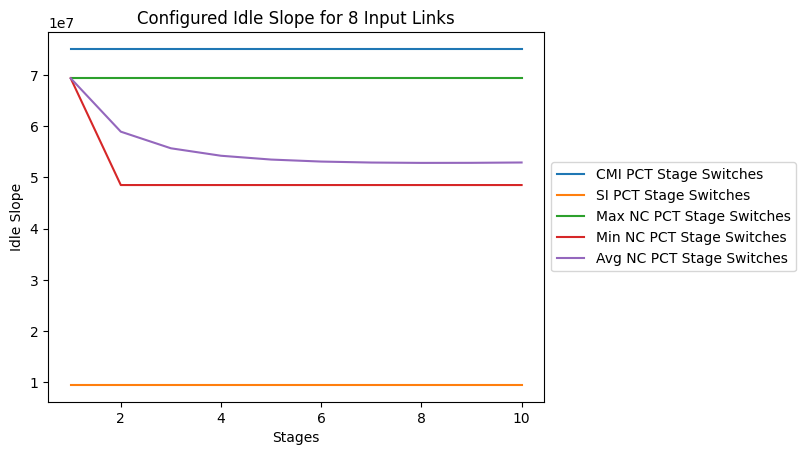

In [69]:
#For stages and 8 Input Links
inputLinks = 8
# plot the aggregate idle slopes from simAggregateIdleSlopes
fig, ax = plt.subplots()
# add the stage slopes
for isScheme in simMaxStageIdleSlopes:
    if isScheme == 'Static':
        continue
    ctScheme = 'PCT'
    slopes = dict()
    for key in simMaxStageIdleSlopes[isScheme][ctScheme]:
        if key[0] == inputLinks:
            slopes[key[1]] = simMaxStageIdleSlopes[isScheme][ctScheme][key]
    slopes = dict(sorted(slopes.items()))
    name = isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
    if isScheme == "NC":
        name = "Max " + name
    ax.plot(slopes.keys(), slopes.values(), label=name)
    if isScheme == "NC":
        slopes = dict()
        for key in simMinStageIdleSlopes[isScheme][ctScheme]:
            if key[0] == inputLinks:
                slopes[key[1]] = simMinStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Min " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        ax.plot(slopes.keys(), slopes.values(), label=name)
        slopes = dict()
        for key in simAvgStageIdleSlopes[isScheme][ctScheme]:
            if key[0] == inputLinks:
                slopes[key[1]] = simAvgStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Avg " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        ax.plot(slopes.keys(), slopes.values(), label=name)
ax.set_xlabel('Stages')
ax.set_ylabel('Idle Slope')
ax.set_title('Configured Idle Slope for ' + str(inputLinks) + ' Input Links')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


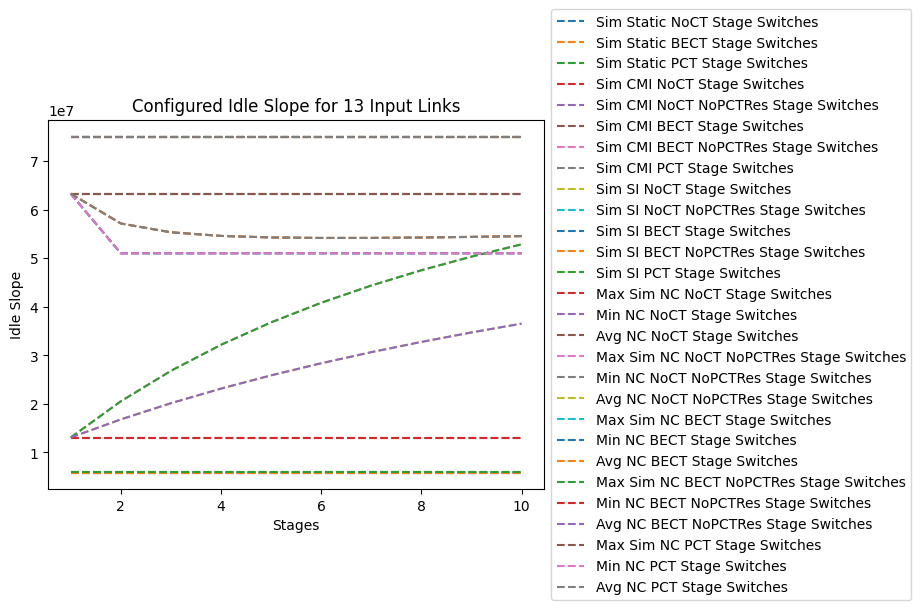

In [68]:
# for stages and 13 input links
inputLinks = 13
fig, ax = plt.subplots()
for isScheme in simAggregateIdleSlopes:
    for ctScheme in simAggregateIdleSlopes[isScheme]:
        slopes = dict()
        for key in simAggregateIdleSlopes[isScheme][ctScheme]:
            if key[0] == inputLinks:
                slopes[key[1]] = simAggregateIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Aggregate Switch'
        ax.plot(slopes.keys(), slopes.values(), label=name)
# add the stage slopes
for isScheme in simMaxStageIdleSlopes:
    for ctScheme in simMaxStageIdleSlopes[isScheme]:
        slopes = dict()
        for key in simMaxStageIdleSlopes[isScheme][ctScheme]:
            if key[0] == inputLinks:
                slopes[key[1]] = simMaxStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        if isScheme == "NC":
            name = "Max " + name
        ax.plot(slopes.keys(), slopes.values(), label=name, linestyle='dashed')
ax.set_xlabel('Stages')
ax.set_ylabel('Idle Slope')
ax.set_title('Configured Idle Slope for ' + str(inputLinks) + ' Input Links')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
        

## Aggregate Delay Analysis

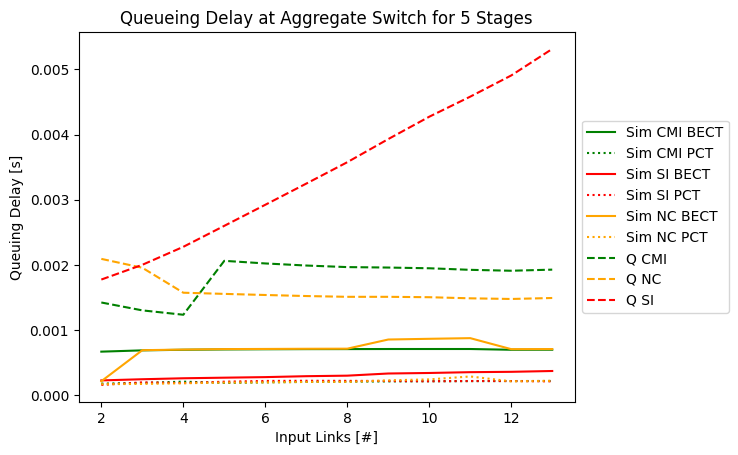

In [66]:
stages = 5
# plot the aggregate delays from simAggregateDelays
fig, ax = plt.subplots()
for isScheme in simAggregateDelays:
    if isScheme == 'Static':
        continue
    for ctScheme in simAggregateDelays[isScheme]:
        if "No" in ctScheme:
            continue
        delays = dict()
        for key in simAggregateDelays[isScheme][ctScheme]:
            if key[1] == stages:
                delays[key[0]] = simAggregateDelays[isScheme][ctScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ")
        line='solid'
        if "BE" not in ctScheme:
            line='dotted'
        ax.plot(delays.keys(), delays.values(), label=name, linestyle=line, color=colorForSchemes[isScheme])
# plot the aggregate delays from qAggregateDelays
for isScheme in qAggregateDelays:
    if isScheme == 'Static':
        continue
    ctScheme = 'PCT'
    # for ctScheme in qAggregateDelays[isScheme]:
    #     if "NoPCTRes" in ctScheme:
    #         continue
    delays = dict()
    for key in qAggregateDelays[isScheme][ctScheme]:
        if key[1] == stages:
            delays[key[0]] = qAggregateDelays[isScheme][ctScheme][key]
    delays = dict(sorted(delays.items()))
    name = "Q " + isScheme
    ax.plot(delays.keys(), delays.values(), label=name, linestyle='dashed', color=colorForSchemes[isScheme])
ax.set_xlabel('Input Links [#]')
ax.set_ylabel('Queuing Delay [s]')
ax.set_title('Queueing Delay at Aggregate Switch for ' + str(stages) + ' Stages')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [152]:
def exportAggregateDelayWithQ(file, exportResults , inputLinks):
    with open(file, "w") as f:
        f.write("numInputLinks,numStages")
        for key in exportResults:
            f.write("," + key)
        f.write("\n")
        for key in exportResults[list(exportResults.keys())[0]]:
            f.write(str(inputLinks) + "," + str(key))
            for scheme in exportResults:
                f.write("," + str(exportResults[scheme][key]))
            f.write("\n")

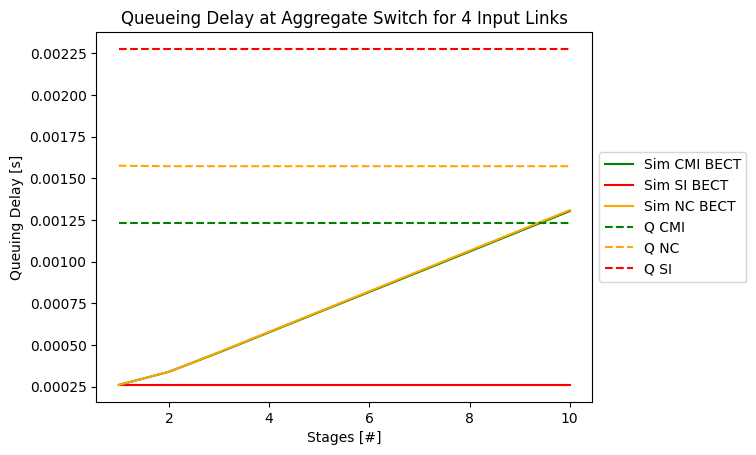

NameError: name 'exportAggregateDelayWithQ' is not defined

In [67]:
exportResults = dict()
# fig, axs = plt.subplots(12, 1, figsize=(10, 40), sharex=True)
fig, ax = plt.subplots()
inputLinks = 4
# for inputLinks in range(2, 14):
    # ax = axs[inputLinks-2]
for isScheme in simAggregateDelays:
    if isScheme == 'Static':
        continue
    # ctScheme = "BECT"
    for ctScheme in simAggregateDelays[isScheme]:
        if "No" in ctScheme or "PCT" in ctScheme:
            continue
        delays = dict()
        for key in simAggregateDelays[isScheme][ctScheme]:
            if key[0] == inputLinks:
                delays[key[1]] = simAggregateDelays[isScheme][ctScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ")
        line='solid'
        if "BE" not in ctScheme:
            line='dotted'
        exportResults["Sim_" + isScheme] = delays
        ax.plot(delays.keys(), delays.values(), label=name, linestyle=line, color=colorForSchemes[isScheme])
for isScheme in qAggregateDelays:
    if isScheme == 'Static':
        continue
    ctScheme = 'PCT'
    delays = dict()
    for key in qAggregateDelays[isScheme][ctScheme]:
        if key[0] == inputLinks:
            delays[key[1]] = qAggregateDelays[isScheme][ctScheme][key]
    delays = dict(sorted(delays.items()))
    name = "Q " + isScheme
    exportResults["Q_" + isScheme] = delays
    ax.plot(delays.keys(), delays.values(), label=name, linestyle='dashed', color=colorForSchemes[isScheme])
    ax.set_title('Queueing Delay at Aggregate Switch for ' + str(inputLinks) + ' Input Links')
ax.set_ylabel('Queuing Delay [s]')
# axs[11].set_xlabel('Stages [#]')
ax.set_xlabel('Stages [#]')
# axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(hspace=0)
plt.show()
exportAggregateDelayWithQ(f"aggregateDelayWithQ{inputLinks}IL.csv", exportResults , inputLinks)


## End 2 End Delays

In [28]:
def getDelayForStagesAndInputLinks(stages, inputLinks, data):
    delay = None
    if (inputLinks,stages) in data:
        delay = data[(inputLinks,stages)]
    return delay

def getDelaysForStage(stage, data):
    delays = dict()
    for key in data:
        if key[1] == stage:
            delay = getDelayForStagesAndInputLinks(stage, key[0], data)
            if delay is not None:
                delays[key[0]] = delay
    return delays

def getDelaysForInputLinks(inputLinks, data):
    delays = dict()
    for key in data:
        if key[0] == inputLinks:
            delay = getDelayForStagesAndInputLinks(key[1], inputLinks, data)
            if delay is not None:
                delays[key[1]] = delay
    return delays

def getDelaysForStudyAndInputLinks(isScheme, ctScheme, inputLinks, minS, maxS, data):
    delays = dict()
    if (isScheme in data) and (ctScheme in data[isScheme]):
        for key in data[isScheme][ctScheme]:
            if key[0] == inputLinks:
                if key[1] >= minS and key[1] <= maxS:
                    delay = getDelayForStagesAndInputLinks(key[1], inputLinks, data[isScheme][ctScheme])
                    if delay is not None:
                        delays[key[1]] = delay
    return delays

def getDelaysForStudyAndStage(isScheme, ctScheme, stage, minIL, maxIL, data):
    delays = dict()
    if (isScheme in data) and (ctScheme in data[isScheme]):
        for key in data[isScheme][ctScheme]:
            if key[1] == stage:
                if key[0] >= minIL and key[0] <= maxIL:
                    delay = getDelayForStagesAndInputLinks(stage, key[0], data[isScheme][ctScheme])
                    if delay is not None:
                        delays[key[0]] = delay
    return delays
    

In [73]:
dncStudiesForCtScheme = {
    "NoCT": ["Static", "CMI_NoCT", "SI_NoCT"],
    "NoCT_NoPCTRes": ["CMI_NoPCTRes", "SI_NoPCTRes"],
    "BECT": ["Static", "CMI_NoCT", "SI_NoCT"],
    "BECT_NoPCTRes": ["CMI_NoPCTRes", "SI_NoPCTRes"],
    "PCT": ["Static"],
}

def plotE2EDelayForInputLinks(ctScheme, IL, minS, maxS, data, ax, linestyle='solid'):
    for isScheme in data:
        if "Static" in isScheme:
            continue
        delays = getDelaysForStudyAndInputLinks(isScheme, ctScheme, IL, minS, maxS, data)
        if delays.__len__() == 0:
            continue
        delays = dict(sorted(delays.items()))
        name = isScheme
        ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes[isScheme], linestyle=linestyle)
    return ax

def plotE2EDelayForStages(ctScheme, S, minIl, maxIl, data, ax, linestyle='solid'):
    for isScheme in data:
        if "Static" in isScheme:
            continue
        delays = getDelaysForStudyAndStage(isScheme, ctScheme, S, minIl, maxIl, data)
        if delays.__len__() == 0:
            continue
        delays = dict(sorted(delays.items()))
        name = isScheme
        ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes[isScheme], linestyle=linestyle)
    return ax

def plotDNCE2EDelayForInputLinks(ctScheme, IL, minS, maxS, data, ax):
    for study in data:
        if "Static" in study:
            continue
        if study not in dncStudiesForCtScheme[ctScheme]:
            continue
        isScheme = study.split('_')[0]
        ct = '_'.join(study.split('_')[1:])
        delays = dict()
        for key in data[study]:
            if key[0] == IL:
                if key[1] >= minS and key[1] <= maxS:
                    delays[key[1]] = data[study][key]
        delays = dict(sorted(delays.items()))
        name = "DNC " + isScheme
        ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes[isScheme], linestyle='dashed')

def plotDNCE2EDelayForStages(ctScheme, S, minIl, maxIl, data, ax):
    for study in data:
        if "Static" in study:
            continue
        if study not in dncStudiesForCtScheme[ctScheme]:
            continue
        isScheme = study.split('_')[0]
        ct = '_'.join(study.split('_')[1:])
        delays = dict()
        for key in data[study]:
            if key[1] == S:
                if key[0] >= minIl and key[0] <= maxIl:
                    delays[key[0]] = data[study][key]
        delays = dict(sorted(delays.items()))
        name = "DNC " + isScheme
        ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes[isScheme], linestyle='dashed')

def plotDYRECTsnE2EDelayForInputLinks(ctScheme, IL, minS, maxS, ax):
    delays = dict()
    for key in ncWcDependentDelays[ctScheme]:
        if key[0] == IL:
            if key[1] >= minS and key[1] <= maxS:
                delays[key[1]] = ncWcDependentDelays[ctScheme][key]
    delays = dict(sorted(delays.items()))
    name = "DYRECTsn Reservation Dependent"
    ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes["NC"], linestyle='dotted')
    # delays = dict()
    # for key in ncWcIndependentDelays[ctScheme]:
    #     if key[0] == IL:
    #         if key[1] >= minS and key[1] <= maxS:
    #             delays[key[1]] = ncWcIndependentDelays[ctScheme][key]
    # delays = dict(sorted(delays.items()))
    # name = "DYRECTsn Reservation Independent"
    # ax.plot(delays.keys(), delays.values(), label=name, color="purple", linestyle='dotted')

def plotDYRECTsnE2EDelayForStages(ctScheme, S, minIl, maxIl, ax):
    #ncWcDependentDelays
    delays = dict()
    for key in ncWcDependentDelays[ctScheme]:
        if key[1] == S:
            if key[0] >= minIl and key[0] <= maxIl:
                delays[key[0]] = ncWcDependentDelays[ctScheme][key]
    delays = dict(sorted(delays.items()))
    name = "DYRECTsn Reservation Dependent"
    ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes["NC"], linestyle='dotted')
    # delays = dict()
    # for key in ncWcIndependentDelays[ctScheme]:
    #     if key[1] == S:
    #         if key[0] >= minIl and key[0] <= maxIl:
    #             delays[key[0]] = ncWcIndependentDelays[ctScheme][key]
    # delays = dict(sorted(delays.items()))
    # name = "DYRECTsn Reservation Independent"
    # ax.plot(delays.keys(), delays.values(), label=name, color="purple", linestyle='dotted')

def plotQE2EDelayForInputLinks(S, IL, minS, maxS, ax):
    for isScheme in qE2EDelays:
        if "Static" in isScheme:
            continue
        delays = dict()
        for key in qE2EDelays[isScheme]:
            if key[1] == S:
                if key[0] >= minS and key[0] <= maxS:
                    delays[key[0]] = qE2EDelays[isScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Q " + isScheme
        ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes[isScheme], linestyle='dashed')

def plotQE2EDelayForStages(ctScheme, S, minIl, maxIl, data, ax):
    for isScheme in qE2EDelays:
        if "Static" in isScheme:
            continue
        delays = dict()
        for key in qE2EDelays[isScheme]:
            if key[1] == S:
                if key[0] >= minIl and key[0] <= maxIl:
                    delays[key[0]] = qE2EDelays[isScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Q " + isScheme
        ax.plot(delays.keys(), delays.values(), label=name, color=colorForSchemes[isScheme], linestyle='dashed')

In [30]:
ctSchemes = list()
for isScheme in simSinkDelays:
    for ctScheme in simSinkDelays[isScheme]:
        if ctScheme not in ctSchemes:
            ctSchemes.append(ctScheme)

End-to-End Delay for dependent on number of input links NoCT


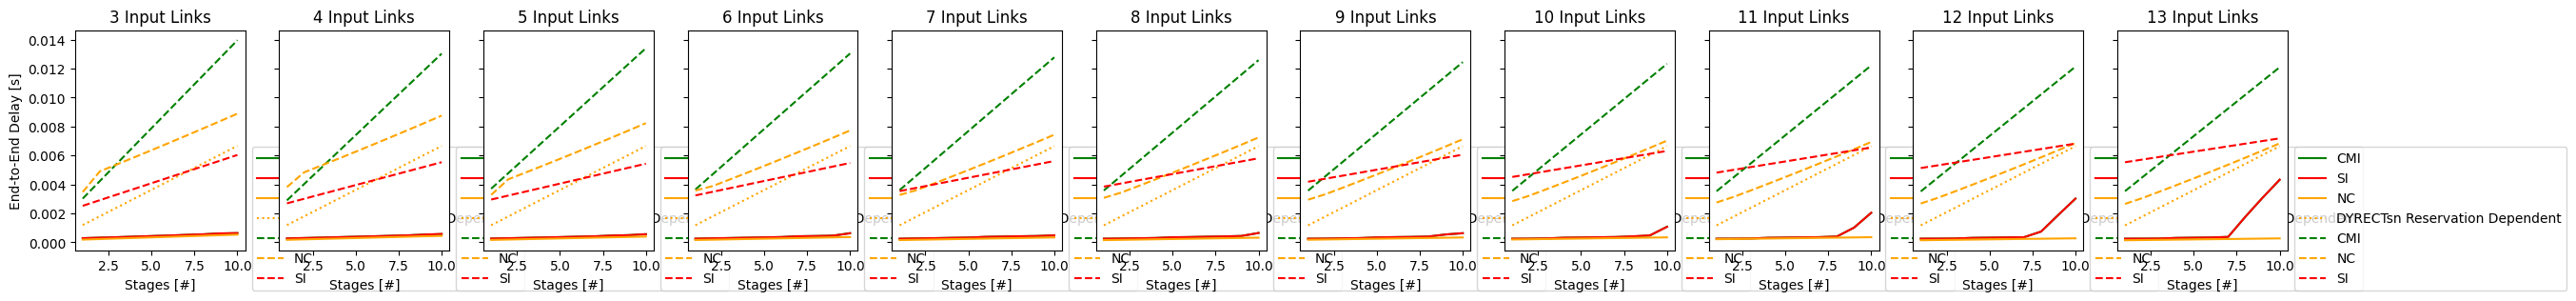

End-to-End Delay for dependent on number of input links BECT


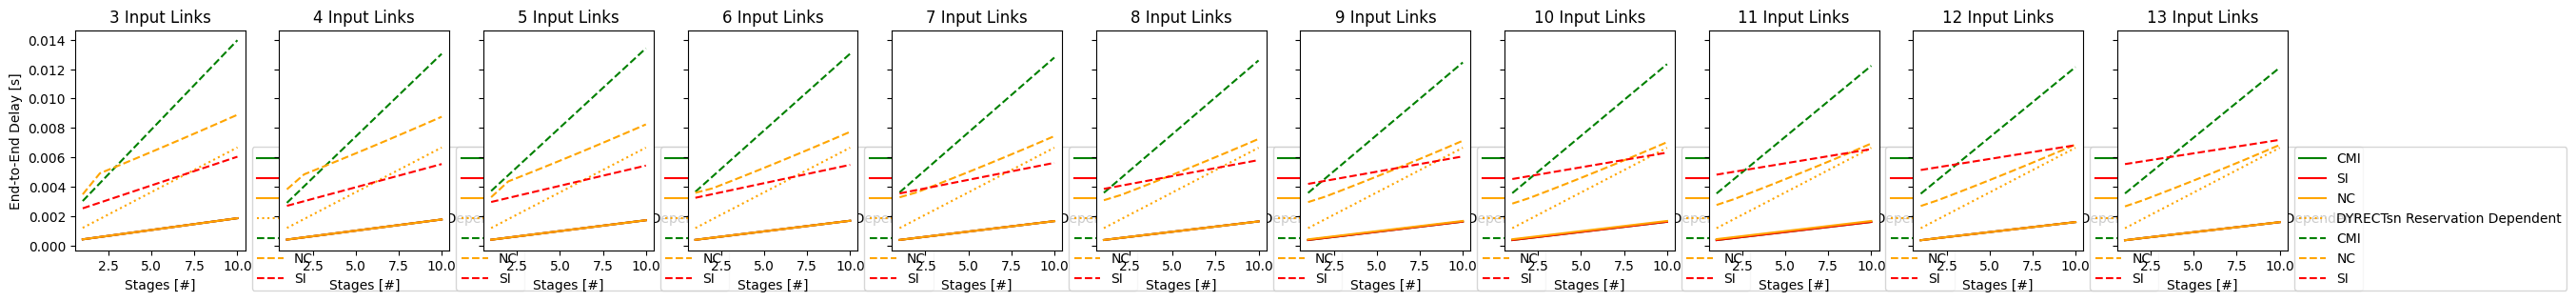

End-to-End Delay for dependent on number of input links PCT


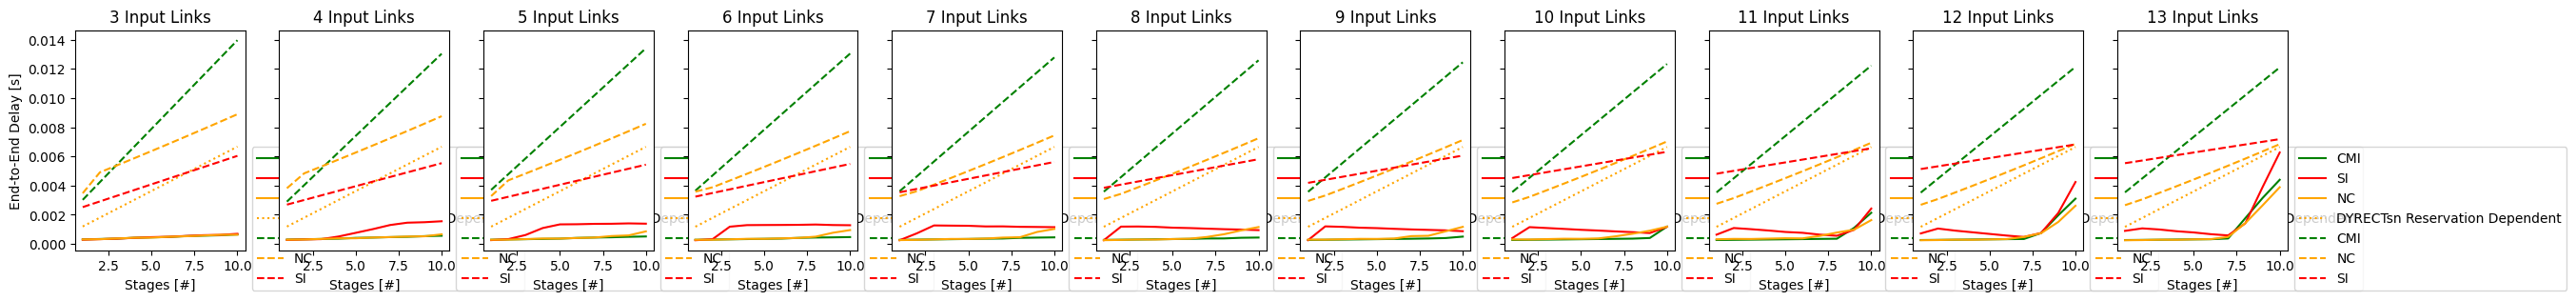

In [74]:
# create 13 small subplots for each ct scheme and input links from 1 to 13
for ctScheme in ctSchemes:
    if "NoPCTRes" in ctScheme:
        continue
    print("End-to-End Delay for dependent on number of input links " + ctScheme)
    # share a y axis 
    fig, axs = plt.subplots(1, 11, figsize=(30, 3), sharey=True)
    for IL in range(3,14):
        ax = axs[IL-3]
        plotE2EDelayForInputLinks(ctScheme, IL, 1, 10, simSinkDelays, ax)
        # plotDNCE2EDelayForInputLinks("NoCT", IL, 1, 10, dncAggregateDelays, ax)
        plotDYRECTsnE2EDelayForInputLinks("PCTRes", IL, 1, 10, ax)
        plotE2EDelayForInputLinks(ctScheme, IL, 1, 10, qE2EDelays, ax, linestyle='dashed')        
        title = str(IL) + " Input Links"
        ax.set_xlabel('Stages [#]')
        ax.set_title(title)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    axs[0].set_ylabel('End-to-End Delay [s]')
    plt.show()    

End-to-End Delay for dependent on number of stages NoCT


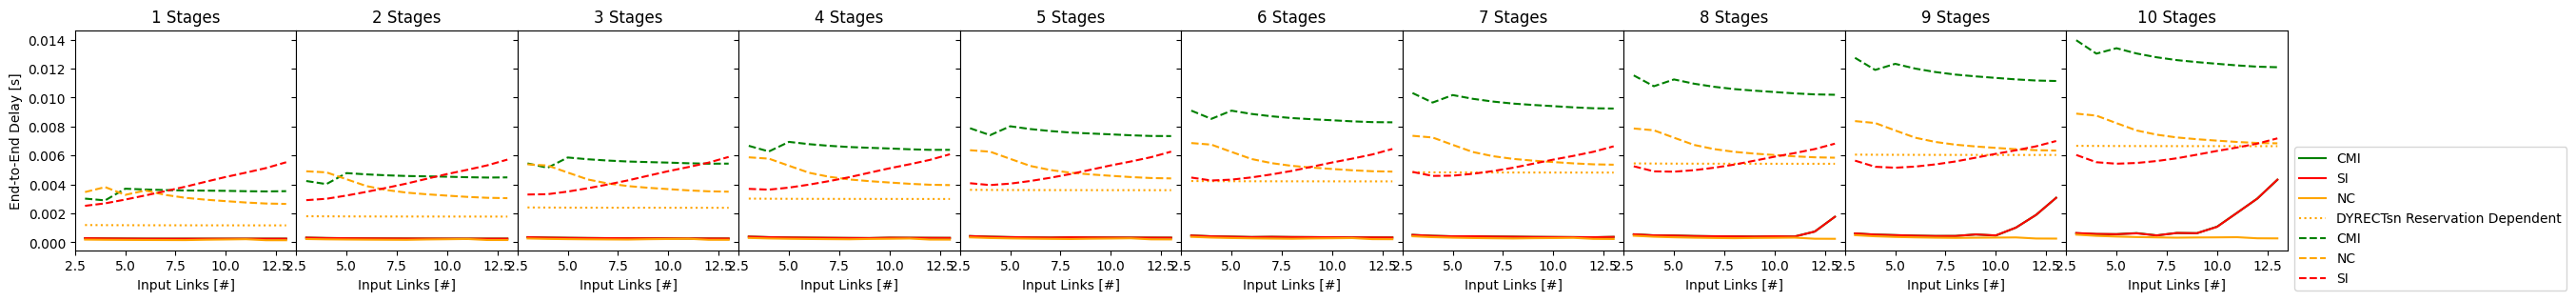

End-to-End Delay for dependent on number of stages BECT


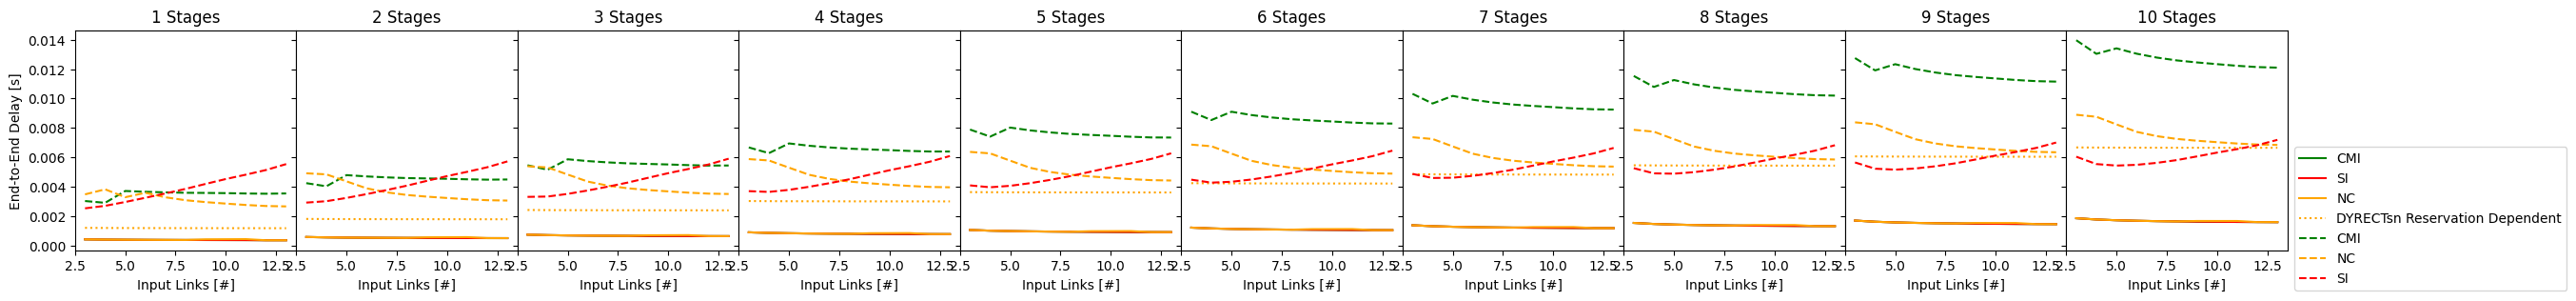

End-to-End Delay for dependent on number of stages PCT


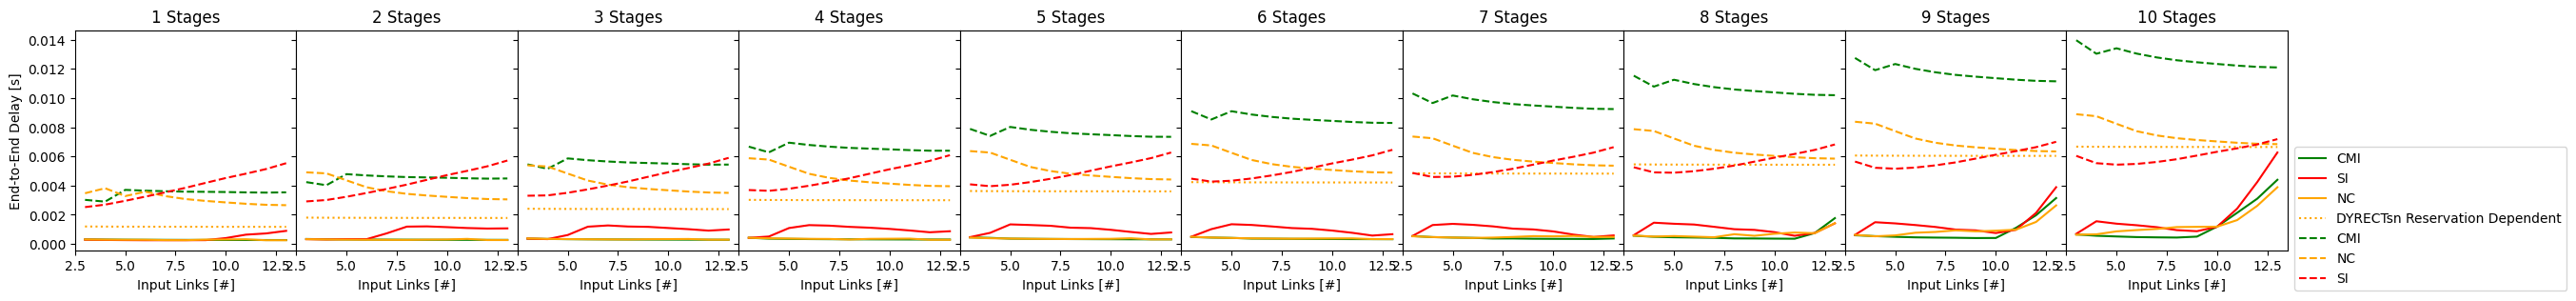

In [75]:
for ctScheme in ctSchemes:
    if "NoPCTRes" in ctScheme:
        continue
    print("End-to-End Delay for dependent on number of stages " + ctScheme)
    # share a y axis
    fig, axs = plt.subplots(1, 10, figsize=(30, 3), sharey=True)
    for S in range(1,11):
        ax = axs[S-1]
        plotE2EDelayForStages(ctScheme, S, 3, 13, simSinkDelays, ax)
        # plotDNCE2EDelayForStages("NoCT", S, 3, 13, dncAggregateDelays, ax)
        plotDYRECTsnE2EDelayForStages("PCTRes", S, 3, 13, ax)
        plotE2EDelayForStages(ctScheme, S, 3, 13, qE2EDelays, ax, linestyle='dashed')
        title = str(S) + " Stages"
        ax.set_xlabel('Input Links [#]')
        ax.set_title(title)
    axs[9].legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    axs[0].set_ylabel('End-to-End Delay [s]')
    #remove gap between subplots
    plt.subplots_adjust(wspace=0)
    plt.show()

# Export DNC Configuration for Study

In [253]:
exportFile = "MaxDelayStudyConfigurations.java"
# export a java class with static getter methods for the data from simAggregateIdleSlopes, simIdleSlopesStages
with open(exportFile, 'w') as file:
    file.write("/**\n")
    file.write(" * This file was generated by a script.\n")
    file.write(" * It contains the lookup tables for the idle slopes of the aggregate and stage switches\n")
    file.write(" * from the simulation and the NC tool for calculation in DNC tool.\n")
    file.write(" */\n")
    file.write("package org.networkcalculus.dnc.demos;\n")
    file.write("\n")
    file.write("import org.apache.commons.math3.util.Pair;\n")
    file.write("import java.util.HashMap;\n")
    file.write("import java.util.Map;\n")
    file.write("\n")
    file.write("public class MaxDelayStudyConfigurations {\n")
    # stage idle slopes data structure
    file.write("    public Map<String, Map<Pair<Integer, Integer>, Integer>> simAggregateIdleSlopes;\n")
    file.write("    public Map<String, Map<Pair<Integer, Integer>, Integer>> simMaxStageIdleSlopes;\n")
    file.write("    public Map<String, Map<Pair<Integer, Integer>, Map<Integer, Integer>> simNCStageIdleSlopes;\n")
    file.write("\n")
    file.write("    public MaxDelayStudyConfigurations() {\n")
    file.write("        initializeSimStageIdleSlope();\n")
    file.write("        initializeSimAggregateIdleSlope();\n")
    file.write("        initializeNCSimStageIdleSlope();\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    private void initializeSimAggregateIdleSlope() {\n")
    file.write("        simAggregateIdleSlopes = new HashMap<>();\n")
    for isScheme in simAggregateIdleSlopes:
        for ctScheme in simAggregateIdleSlopes[isScheme]:
            file.write("        initializeSimAggregateIdleSlope_" + isScheme + "_" + ctScheme + "();\n")
    file.write("    }\n")
    file.write("\n")
    for isScheme in simAggregateIdleSlopes:
        for ctScheme in simAggregateIdleSlopes[isScheme]:
            file.write("    private void initializeSimAggregateIdleSlope_" + isScheme + "_" + ctScheme + "() {\n")
            file.write("        simAggregateIdleSlopes.put(\"" + isScheme + "_" + ctScheme + "\", new HashMap<>());\n")
            for key in simAggregateIdleSlopes[isScheme][ctScheme]:
                file.write("        simAggregateIdleSlopes.get(\"" + isScheme + "_" + ctScheme + "\").put(new Pair<>(" + str(key[0]) + ", " + str(key[1]) + "), " + str(simAggregateIdleSlopes[isScheme][ctScheme][key]) + ");\n")
            file.write("    }\n")
            file.write("\n")  
    file.write("    private void initializeSimStageIdleSlope() {\n")
    file.write("        simMaxStageIdleSlopes = new HashMap<>();\n")
    for isScheme in simMaxStageIdleSlopes:
        for ctScheme in simMaxStageIdleSlopes[isScheme]:
            file.write("        initializeSimStageIdleSlope_" + isScheme + "_" + ctScheme + "();\n")
    file.write("    }\n")
    file.write("\n")
    for isScheme in simMaxStageIdleSlopes:
        if isScheme == 'NC':
            continue
        for ctScheme in simMaxStageIdleSlopes[isScheme]:
            file.write("    private void initializeSimStageIdleSlope_" + isScheme + "_" + ctScheme + "() {\n")
            file.write("        simMaxStageIdleSlopes.put(\"" + isScheme + "_" + ctScheme + "\", new HashMap<>());\n")
            for key in simMaxStageIdleSlopes[isScheme][ctScheme]:
                file.write("        simMaxStageIdleSlopes.get(\"" + isScheme + "_" + ctScheme + "\").put(new Pair<>(" + str(key[0]) + ", " + str(key[1]) + "), " + str(simMaxStageIdleSlopes[isScheme][ctScheme][key]) + ");\n")
            file.write("    }\n")
            file.write("\n")       
    ## special treatment for NC
    file.write("    private void initializeNCSimStageIdleSlope() {\n")
    file.write("        simNCStageIdleSlopes = new HashMap<>();\n")
    for ctScheme in simNcStageIdleSlopes["NC"]:
        file.write("        initializeNCSimStageIdleSlope_" + ctScheme + "();\n")
    file.write("    }\n")
    file.write("\n")
    for ctScheme in simNcStageIdleSlopes["NC"]:
        file.write("    private void initializeNCSimStageIdleSlope_" + ctScheme + "() {\n")
        file.write("        simNCStageIdleSlopes.put(\"" + isScheme + "_" + ctScheme + "\", new HashMap<>());\n")
        for key in simNcStageIdleSlopes["NC"][ctScheme]:
            file.write("        initializeNCSimStageIdleSlope_" + ctScheme + "_IL_" + str(key[0]) + "_S_" + str(key[1]) + "();\n")
        file.write("    }\n")
        file.write("\n")
    for ctScheme in simNcStageIdleSlopes["NC"]:
        for key in simNcStageIdleSlopes["NC"][ctScheme]:
            file.write("    private void initializeNCSimStageIdleSlope_" + ctScheme + "_IL_" + str(key[0]) + "_S_" + str(key[1]) + "() {\n")
            file.write("        simNCStageIdleSlopes.get(\"" + isScheme + "_" + ctScheme + "\").put(new Pair<>(" + str(key[0]) + ", " + str(key[1]) + "), new HashMap<>());\n")
            for stage in simNcStageIdleSlopes["NC"][ctScheme][key]:
                file.write("        simNCStageIdleSlopes.get(\"" + isScheme + "_" + ctScheme + "\").get(new Pair<>(" + str(key[0]) + ", " + str(key[1]) + ")).put(" + str(stage) + ", " + str(simNcStageIdleSlopes["NC"][ctScheme][key][stage]) + ");\n")
            file.write("    }\n")
            file.write("\n")
    # getter methods
    file.write("    public int getSimStageIdleSlope(String study, int inputLinks, int stages) {\n")
    file.write("        return simMaxStageIdleSlopes.get(study).get(new Pair<>(inputLinks, stages));\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    public int getSimAggregateIdleSlope(String study, int inputLinks, int stages) {\n")
    file.write("        return simAggregateIdleSlopes.get(study).get(new Pair<>(inputLinks, stages));\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    public int getNCSimStageIdleSlope(String study, int inputLinks, int stages, int currentStage) {\n")
    file.write("        return simNCStageIdleSlopes.get(study).get(new Pair<>(inputLinks, stages)).get(currentStage);\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    public boolean existsSimScenario(String study, int inputLinks, int stages) {\n")
    file.write("        if (!(simNCStageIdleSlopes.containsKey(study) && simNCStageIdleSlopes.get(study).containsKey(new Pair<>(inputLinks, stages)))\n")
    file.write("            && !(simMaxStageIdleSlopes.containsKey(study) && simMaxStageIdleSlopes.get(study).containsKey(new Pair<>(inputLinks, stages)))) {\n")
    file.write("            return false;\n")
    file.write("        }\n")
    file.write("        return simAggregateIdleSlopes.containsKey(study) && simAggregateIdleSlopes.get(study).containsKey(new Pair<>(inputLinks, stages));\n")
    file.write("    }\n")


    # main test method
    file.write("    public static void main(String[] args) {\n")
    file.write("        MaxDelayStudyConfigurations config = new MaxDelayStudyConfigurations();\n")
    file.write("        System.out.println(config.existsSimScenario(\"Static_NoCT\", 13, 8) + \" should be true\");\n")
    file.write("        System.out.println(config.existsSimScenario(\"NC_PCT\", 9, 4) + \" should be true\");\n")
    file.write("        System.out.println(config.existsSimScenario(\"Should_Not_Exist\", 13, 8) + \" should be false\");\n")
    file.write("        System.out.println(config.getSimStageIdleSlope(\"Static_NoCT\", 13, 8) + \" should be 75000000\");\n")
    file.write("        System.out.println(config.getSimAggregateIdleSlope(\"Static_NoCT\", 13, 8) + \" should be 75000000\");\n")
    file.write("        System.out.println(config.getNCSimStageIdleSlope(\"NC_PCT\", 9, 4, 1) + \" should be 50579485\");\n")
    file.write("    }\n")
    file.write("}\n")
    file.write("\n")


# Sim Par Generation

In [28]:
totalBandwidth = 75000000
linkrate = 100000000
talkerInterval = 0.000125
ctInterval = 0.1
talkerSize = floor(((totalBandwidth / 8) * talkerInterval)/3)
talkerSizeAsStr = "floor(((" + str(totalBandwidth) + " / 8) * " + str(talkerInterval) + ") / ${IL})"
print("talkerSize " + talkerSizeAsStr)
ctSize = floor(((totalBandwidth / 8) * talkerInterval) - (((totalBandwidth / 8) * talkerInterval) / 3))
ctSizeAsStr = "floor(((" + str(totalBandwidth) + " / 8) * " + str(talkerInterval) + ") - (((" + str(totalBandwidth) + " / 8) * " + str(talkerInterval) + ") / ${IL}))"
print("ctSize " + ctSizeAsStr)
idleslope = (talkerSize*8 / talkerInterval) + (ctSize*8 / ctInterval)
idleslopeAsStr = "((" + talkerSizeAsStr + " * 8 / " + str(talkerInterval) + ") + (" + ctSizeAsStr + " * 8 / " + str(ctInterval) + "))"
print("idleslope " + idleslopeAsStr)
sendslope = (linkrate - idleslope) / linkrate
sendslopeAsStr = "(" + str(linkrate) + " - " + idleslopeAsStr + ") / " + str(linkrate)
print("sendslope " + sendslopeAsStr)
delay = (((ctSize * 8) * sendslope) / idleslope)
delayAsStr = "(((" + ctSizeAsStr + " * 8) * " + sendslopeAsStr + ") / " + idleslopeAsStr + ")"
print("delay " + delayAsStr)
delay

talkerSize floor(((75000000 / 8) * 0.000125) / ${IL})
ctSize floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL}))
idleslope ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1))
sendslope (100000000 - ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1))) / 100000000
delay (((floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8) * (100000000 - ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1))) / 100000000) / ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1)))


0.0001872154738299321